# **One-shot learning en la clasificación de razas de perros**
---

*   Alumno: Marco Antonio Garrido Mesías
*   Profesor: Jorge Ramón Vergara Quezada
*   Asignatura: Machine Learning 2020







# Información GPU

In [1]:
! nvidia-smi

Wed Aug 12 10:48:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P5     7W /  N/A |   1110MiB /  4096MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# 1. Código





## 1.1 Librerías 

In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## 1.2 Conexión a carpeta drive (Si aplica)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#%cd /content/drive/My\ Drive/Colab Notebooks/Trabajo Machine Learning/siamese-fruits-detector-master/
#!pwd

## 1.3 Detección de CUDA

In [5]:
device = torch.device('cuda:0' if (torch.cuda.is_available()) else 'cpu')
device

device(type='cuda', index=0)

## 1.4 Funciones

In [6]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## 1.5 Clases

In [7]:
class Config():
    training_dir = "./datasets/dogs/training/" #Directorio de datos de entrenamiento
    testing_dir = "./datasets/dogs/testing/" #Directorio de datos de testeo
    learning_rate = 0.0005
    train_batch_size = 64 #Tamaño del lote
    train_number_epochs = 100 #Cantidad de repeticiones en la etapa de entrenamiento

In [8]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [9]:
class SiameseNetwork(nn.Module): #Clase correspondiente a la configuración de la red siamesa
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

### Función de pedida constrastiva

La función de perdida constrastiva esta definida de la siguiente manera:
![texto alternativo](https://hackernoon.com/hn-images/1*tzGB6D97tHWR_-NJ8FKknw.jpeg)

En donde se tiene:
<br> • Y = Salida que puede ser 0 si los inputs son de la misma clase y 1 si son diferentes.</br>
<br> • X1, X2 = Entradas al sistema </br>
<br> •	W = Peso de la red.</br>
<br> •	Dw = Distancia euclidiana entre las dos salidas </br> 


In [10]:
class ContrastiveLoss(torch.nn.Module): #Clase de función de perdida constastiva 

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## 1.6 Carga del dataset

In [11]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [12]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

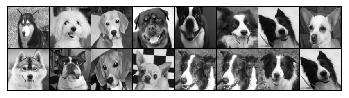

In [13]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))


In [14]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

## 1.7 Entrenamiento

In [15]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = Config.learning_rate)

In [16]:
counter = []
loss_history = [] 
iteration_number= 0

Repeticion 0
 Perdida actual: 1.7049838304519653

Repeticion 1
 Perdida actual: 40.85422134399414

Repeticion 2
 Perdida actual: 15.741147994995117

Repeticion 3
 Perdida actual: 6.616652965545654

Repeticion 4
 Perdida actual: 4.505947589874268

Repeticion 5
 Perdida actual: 2.891360282897949

Repeticion 6
 Perdida actual: 2.7928459644317627

Repeticion 7
 Perdida actual: 4.06256103515625

Repeticion 8
 Perdida actual: 3.1580543518066406

Repeticion 9
 Perdida actual: 2.8474764823913574

Repeticion 10
 Perdida actual: 2.0142972469329834

Repeticion 11
 Perdida actual: 2.335571527481079

Repeticion 12
 Perdida actual: 3.01885724067688

Repeticion 13
 Perdida actual: 4.036889553070068

Repeticion 14
 Perdida actual: 2.0782225131988525

Repeticion 15
 Perdida actual: 2.4447216987609863

Repeticion 16
 Perdida actual: 1.740830898284912

Repeticion 17
 Perdida actual: 3.0129053592681885

Repeticion 18
 Perdida actual: 3.0163352489471436

Repeticion 19
 Perdida actual: 2.1530144214630127

R

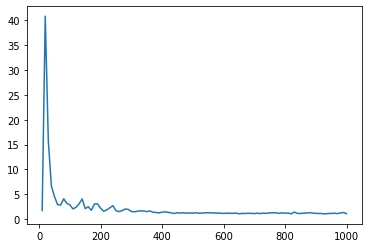

In [17]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Repeticion {}\n Perdida actual: {}\n".format(epoch,loss_contrastive.data))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data)
show_plot(counter,loss_history)

## 1.8 Test de la red

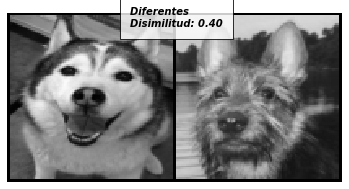

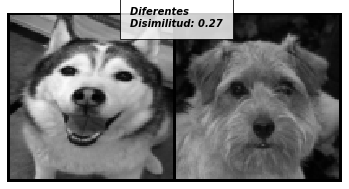

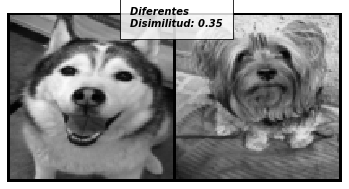

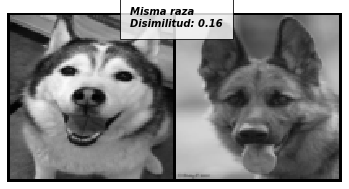

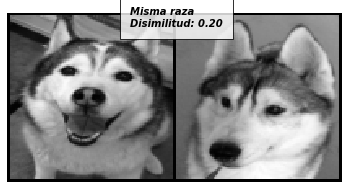

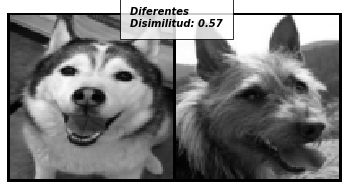

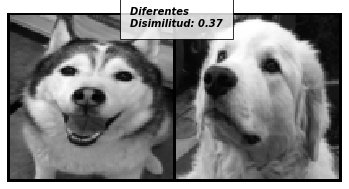

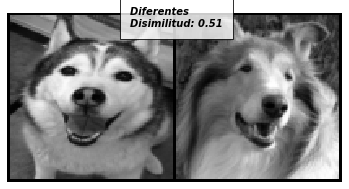

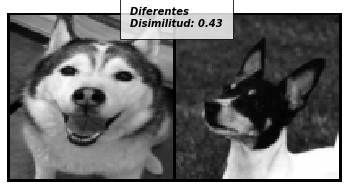

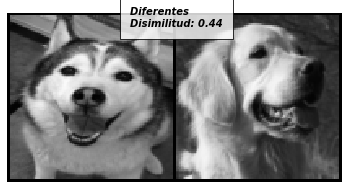

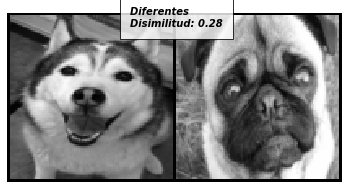

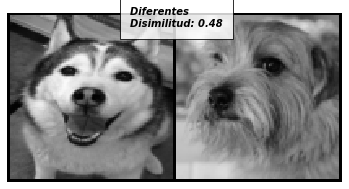

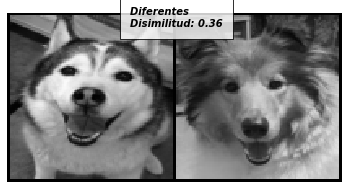

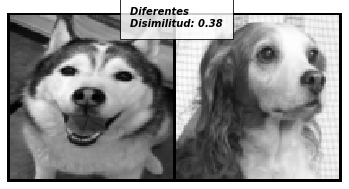

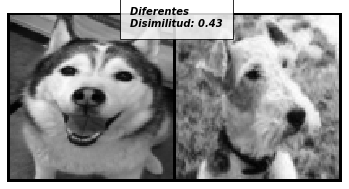

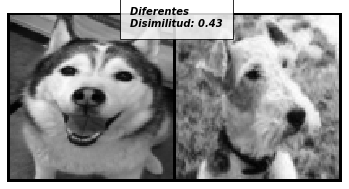

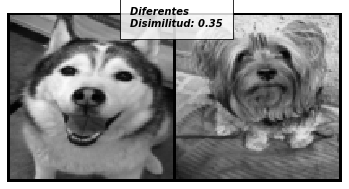

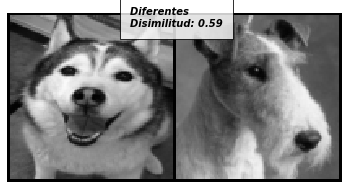

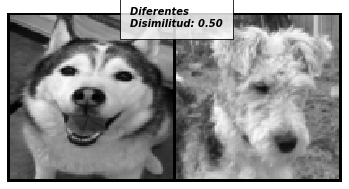

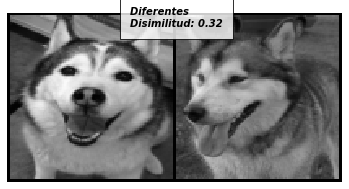

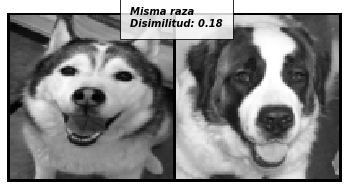

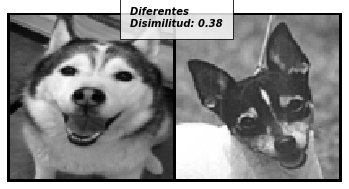

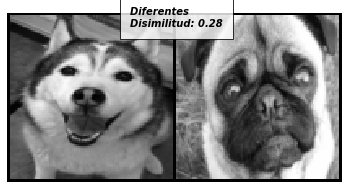

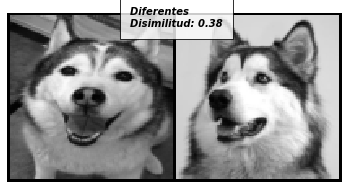

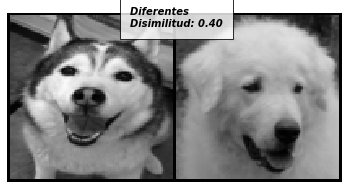

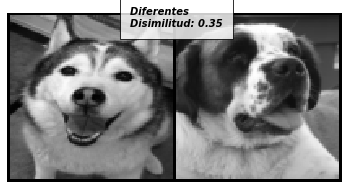

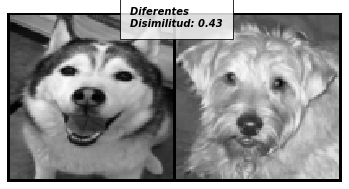

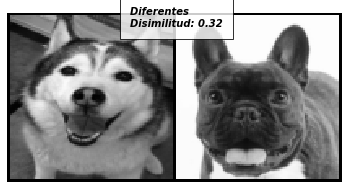

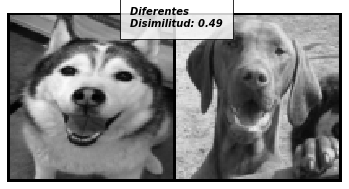

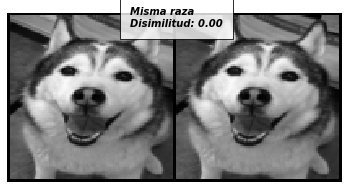

Misma:  4
Diferente:  26


In [42]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,path = next(dataiter)

cont_same = 0
cont_diff = 0

for i in range(30):
    _ ,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    salida1, salida2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    distancia_eucladiana = F.pairwise_distance(salida1, salida2)
    if(distancia_eucladiana < 0.25):
        same = "Misma raza"
        cont_same +=1
    else:
        same = "Diferentes"
        cont_diff +=1
        
    imshow(torchvision.utils.make_grid(concatenated),'{} \nDisimilitud: {:.2f}'.format(same, distancia_eucladiana.item()))
print("Misma: ", cont_same)
print("Diferente: ", cont_diff)